In [7]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from time import time
from os import getcwd

pd.set_option('notebook_repr_html', True, 'max_columns', 0)
%matplotlib inline

## <u>Understanding the project</u><br>
Our aim is to try and predict the outcome of an animal arriving at the animal shelter, 
based on a few known features (Name, Age, Type etc...).
The training set contains a large number of entries. Each entry (row) represnets an animal, 
its known fetaures, and the outcome of the animal after it visited the shelter.
We will try to use existing features in order to derive new features we believe will help predict the outcome, visualize the features
and try to arrive at conclusions based on the visualizations.
This process will help us understand the data, the problem and how to tackle them.
We excluded the Datetime feature and the OutcomeSubType features 
because this information is only available at the time of outcome and shouldn't be used to predict the outcome.

In [8]:
# load initial data
file = 'train.csv'
train_data = pd.read_csv(file)
train_data.head(10)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


In [9]:
# no animal IDs without A - we can remove the A and make it a number for better indexing
train_data[train_data['AnimalID'].str[:1] != 'A'] 

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color


In [10]:
train_data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [11]:
train_data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [12]:
######### Since 'Died' is a very small percentage of the outcome, we decided to remove it from the possible outcomes.
# train_data = train_data[train_data.OutcomeType != 'Died']
# train_data = train_data[train_data.SexuponOutcome != 'Unknown']

# remove preceding 'A' and change AnimalID column to int
train_data['AnimalID'] = train_data['AnimalID'].str[1:]
train_data['AnimalID'] = train_data['AnimalID'].astype('int32')

# set AnimalID as index
train_data.set_index('AnimalID', inplace=True)

# change DateTime column to datetime
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

In [13]:
train_data.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,6374,22918,5,16,2,5,44,1380,366
top,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,10769,7816,15595,9779,3969,8810,2824
first,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# looking at the datafrmae and the values in it, we decided to derive the following features out of it, because we believe they will be helpful in finding meaningful trends
train_data['HasName'] = (train_data.Name.str.len() > 0)

train_data[['Intact','Sex']] = train_data.SexuponOutcome.str.split(expand=True)
# train_data['Intact'] = train_data.Intact == 'Intact'
train_data['Intact'] = np.where(train_data.Intact.isin(['Spayed','Neutered']), False, train_data.Intact)
train_data['Intact'] = np.where(train_data.Intact == 'Intact', True, train_data.Intact)

train_data[['Breed1','Breed2','Breed3']] = train_data.Breed.str.split('/',expand=True)

train_data[['Color1','Color2']] = train_data.Color.str.split('/',expand=True)

train_data['Purebreed'] = ~(train_data.Breed1.str.contains('Mix')) & train_data.Breed2.isna()

train_data['SingleColor'] = train_data.Color2.isna()

#apply seems to wipe the describe data - not sure how to avoid this
train_data.head(10)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,Breed1,Breed2,Breed3,Color1,Color2,Purebreed,SingleColor
AnimalID,,,,,,,,,,,,,,,,,,,
671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,False,Male,Shetland Sheepdog Mix,None,None,Brown,White,False,False
656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,True,False,Female,Domestic Shorthair Mix,None,None,Cream Tabby,None,False,True
686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,False,Male,Pit Bull Mix,None,None,Blue,White,False,False
683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,False,True,Male,Domestic Shorthair Mix,None,None,Blue Cream,None,False,True
667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,False,False,Male,Lhasa Apso,Miniature Poodle,None,Tan,None,False,True
677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,True,True,Female,Cairn Terrier,Chihuahua Shorthair,None,Black,Tan,False,False
699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,True,True,Male,Domestic Shorthair Mix,None,None,Blue Tabby,None,False,True
701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,False,Unknown,None,Domestic Shorthair Mix,None,None,Brown Tabby,None,False,True
671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,True,False,Female,American Pit Bull Terrier Mix,None,None,Red,White,False,False


In [15]:
train_data.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,Breed1,Breed2,Breed3,Color1,Color2,Purebreed,SingleColor
count,19038,26729,26729,13117,26729,26728,26711,26729,26729,26729,26728,25635,26729,3058,10,26729,13924,26729,26729
unique,6374,22918,5,16,2,5,44,1380,366,2,3,2,382,143,4,57,44,2,2
top,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,True,False,Male,Domestic Shorthair Mix,Labrador Retriever,Tan Hound,Black,White,False,False
freq,136,19,10769,7816,15595,9779,3969,8810,2824,19038,18599,13304,8810,359,6,6422,8854,25338,13924
first,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# We want to convert the AgeuponOutcome column to a standard value in days
def ConvertDays(age):
    if age==None: return None
    if(' ' not in str(age)): return None
    value,unit = str(age).split()
    if 'year' in unit: return 365*int(value)
    if 'month' in unit: return 30*int(value)
    if 'week' in unit: return 7*int(value)
    if 'day' in unit:return int(value)
    return None

train_data['Age'] = train_data.AgeuponOutcome.apply(ConvertDays)


In [17]:
# Let's check if some animals visited the shelter more than once
print(train_data.index.nunique(), len(train_data))
# We can't tell if an animal visited more than once, since they seem to get a new AnimalID each visit.

26729 26729


In [18]:
#Now that we derived new features from the existing ones, let's try to visualize the data and understand the data better:
animal_type_xt = pd.crosstab(index=train_data.AnimalType,
                             columns=train_data.OutcomeType,
                             normalize='index'
                            )
animal_type_xt

OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
AnimalType,,,,,
Cat,0.383690,0.013203,0.063769,0.044907,0.494431
Dog,0.416608,0.003206,0.054184,0.274832,0.251170


<i>We can see that there's a small chance of the pet being euthanised.
however, dogs are much more likely to be returned to the owner than cats, which are more likely to be transferred.</i>

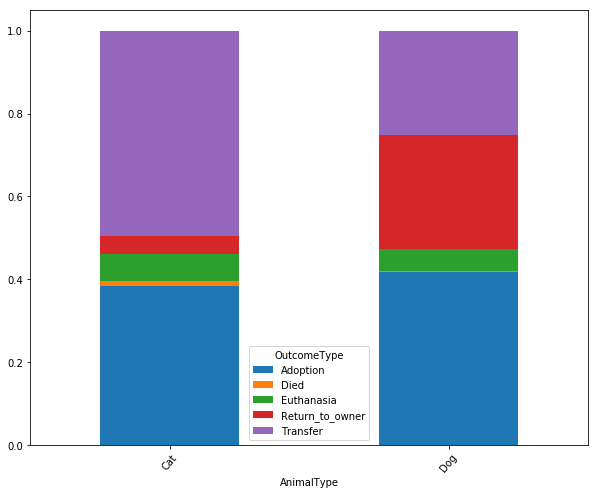

In [19]:
animal_type_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)

In [20]:
name_xt = pd.crosstab(index=[train_data.AnimalType,train_data.HasName],
                             columns=[train_data.OutcomeType],
                             normalize='index')
name_xt

OutcomeType         Adoption      Died    ...     Return_to_owner  Transfer
AnimalType HasName                        ...                              
Cat        False    0.128711  0.018330    ...            0.008767  0.733812
           True     0.592968  0.008994    ...            0.074571  0.297956
Dog        False    0.386228  0.010479    ...            0.040793  0.464820
           True     0.422889  0.001702    ...            0.323222  0.206995

[4 rows x 5 columns]

<i>We can see that both for cats and dogs having a name increases the chance of returning to owner.
which makes sense as having a name seems to indicate a (previous) owner.
It is also interesting to note that for cats, having a name increased adpotion rate significantly, while for dogs the adoption rate stays the same, but the chance of returning to owner increases.
Are the animals more domesticated, healthier , or is it a psychological effect on potential adopters?
It would be interesting to test if naming all animals produces better adoption results</i>

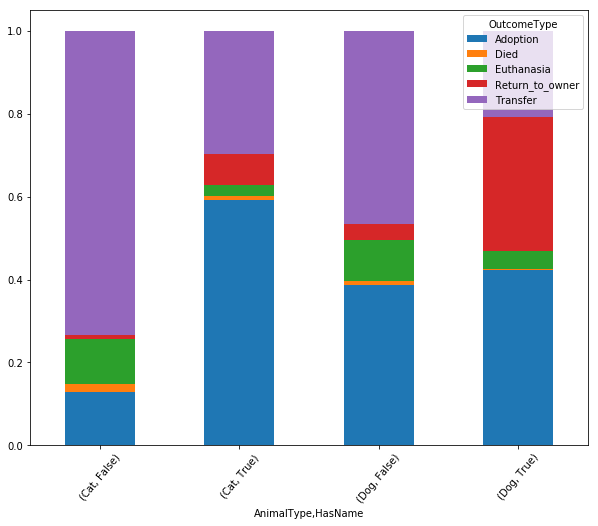

In [21]:
name_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)



In [22]:
intact_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Intact],
                             columns=[train_data.OutcomeType],
                             normalize='index')
intact_xt

OutcomeType         Adoption      Died    ...     Return_to_owner  Transfer
AnimalType Intact                         ...                              
Cat        False    0.663814  0.003291    ...            0.076518  0.226263
           True     0.058896  0.025736    ...            0.006929  0.800297
           Unknown  0.000000  0.022638    ...            0.006890  0.881890
Dog        False    0.509024  0.001358    ...            0.281904  0.176330
           True     0.041068  0.010351    ...            0.250417  0.550918
           Unknown  0.000000  0.025974    ...            0.064935  0.766234

[6 rows x 5 columns]

<i>There is a very strong correlation between neutered/spayed animals and adoption.
Possibly this indicates a preference for neutered animals.
Alternatively the adoption is the cause and not the effect (if the neutering is part of the adoption process)</i>

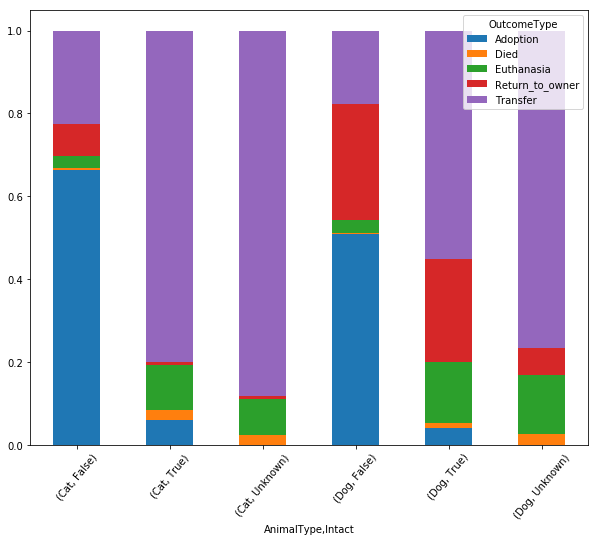

In [23]:
intact_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)

In [24]:
purebreed_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Purebreed],
                             columns=[train_data.OutcomeType],
                             normalize='index')
purebreed_xt.head()


OutcomeType           Adoption      Died    ...     Return_to_owner  Transfer
AnimalType Purebreed                        ...                              
Cat        False      0.382318  0.013142    ...            0.044757  0.495818
           True       0.442688  0.015810    ...            0.051383  0.434783
Dog        False      0.426506  0.003182    ...            0.266930  0.248392
           True       0.290861  0.003515    ...            0.375220  0.286467

[4 rows x 5 columns]

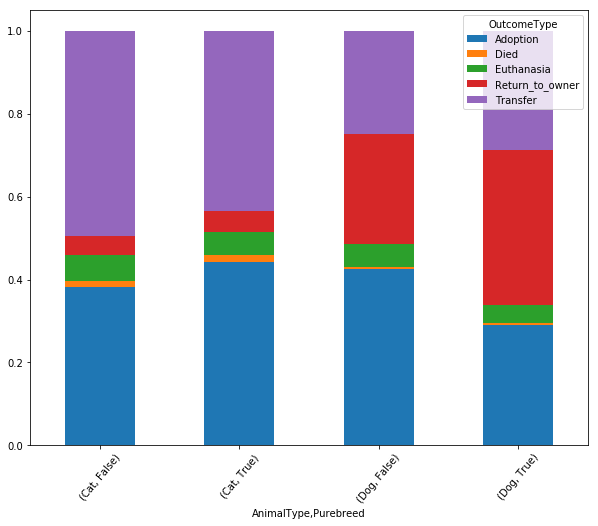

In [25]:
purebreed_xt.plot.bar(stacked=True, figsize=(10,8), rot=50)
#we see no significant correlation between outcome and pure vs. mixed breeds

In [26]:
# We will try and reduce the number of breed types to the most popular ones and try to find some correlation to the outcome:
d1 = train_data[['AnimalType','OutcomeType','Breed1']].copy()
d1['Breed'] = d1.Breed1
d1 = d1.drop('Breed1', axis = 1)

d2 = train_data[['AnimalType','OutcomeType','Breed2']].copy()
d2['Breed'] = d2.Breed2
d2 = d2.drop('Breed2', axis = 1)

d3 = train_data[['AnimalType','OutcomeType','Breed3']].copy()
d3['Breed'] = d3.Breed3
d3 = d3.drop('Breed3', axis = 1)
breed_data = d1.append(d2).append(d3)
cat_filtered_breed_data = breed_data[breed_data.AnimalType=='Cat']
cat_filtered_breed_data = cat_filtered_breed_data.groupby('Breed').filter(lambda x: len(x) >= 100)
filtered_breed_data = breed_data.groupby('Breed').filter(lambda x: len(x) >= 500)
filtered2_breed_data = breed_data.groupby('Breed').filter(lambda x: (len(x) >= 100) & (len(x)<500))
#print(d1.shape, d2.shape, d3.shape,breed_data.shape)
dog_filtered_breed_data = filtered_breed_data[filtered_breed_data.AnimalType=='Dog']
dog2_filtered_breed_data = filtered2_breed_data[filtered2_breed_data.AnimalType=='Dog']


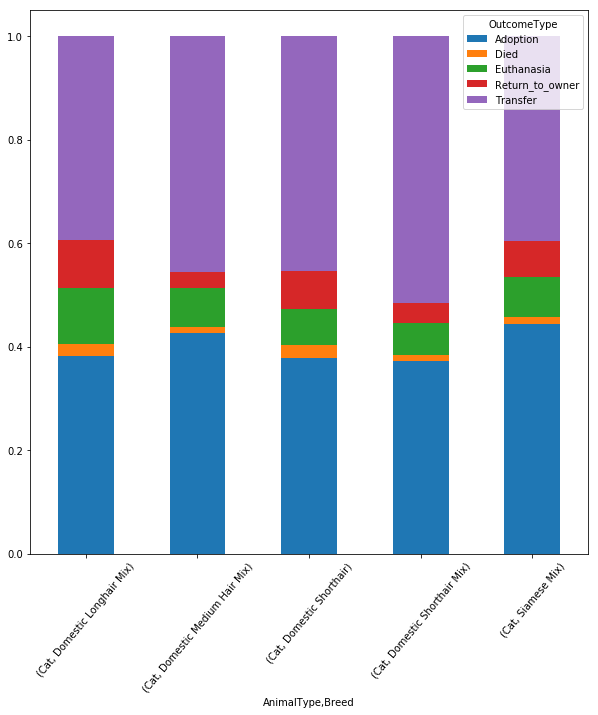

In [27]:
cat_breed_xt = pd.crosstab(index=[cat_filtered_breed_data.AnimalType,cat_filtered_breed_data.Breed],
                             columns=[cat_filtered_breed_data.OutcomeType],
                             normalize='index')
cat_breed_xt.plot.bar(stacked=True, figsize=(10,10),rot=50)
#we see no significant correlation between cat breed and outcome (breed with at least 100 sample size)

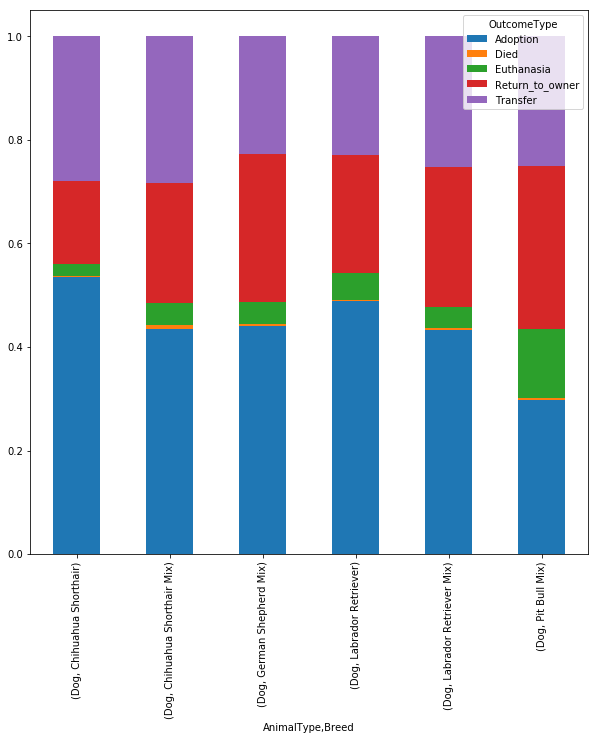

In [28]:
dog1_breed_xt = pd.crosstab(index=[dog_filtered_breed_data.AnimalType,dog_filtered_breed_data.Breed],
                             columns=[dog_filtered_breed_data.OutcomeType],
                             normalize='index')

dog1_breed_xt.plot.bar(stacked=True, figsize=(10,10))
#dog breed with at least 500 sample size

### <u><i>dog breed with sample size 100 to 500<br></u>
Overall there doesn't seem to be a strong correlation between breed and adoption although 
Shih Tzu Mix breeds show particularly poor adoption rates, however this may be due to a small sample size.</i>

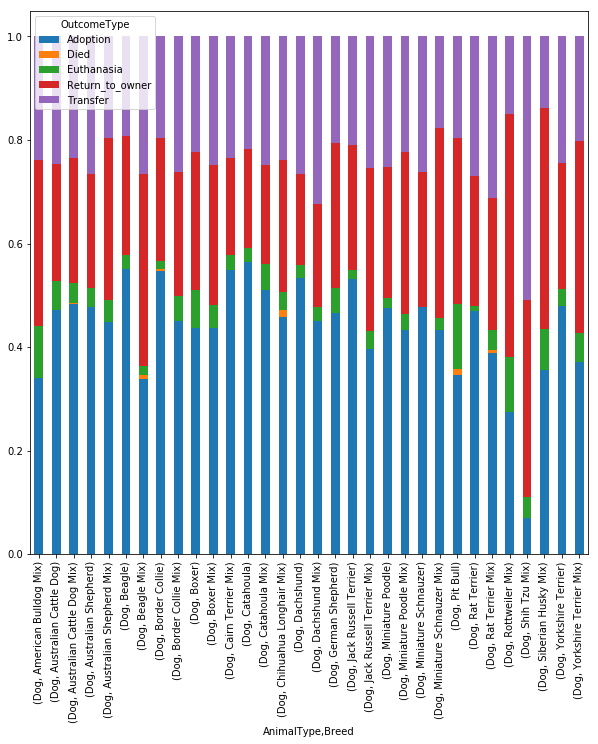

In [29]:
dog2_breed_xt = pd.crosstab(index=[dog2_filtered_breed_data.AnimalType,dog2_filtered_breed_data.Breed],
                             columns=[dog2_filtered_breed_data.OutcomeType],
                             normalize='index')

dog2_breed_xt.plot.bar(stacked=True, figsize=(10,10))


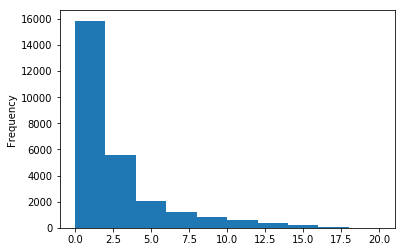

In [30]:
#Since AguponOutcome is hard to work with in its current form (years, months, weeks), and the age by days range is too big, we'll add a new feature of age by years
# bins = pd.IntervalIndex.from_tuples([(x-365, x) for x in range(365, 31*365, 365)])
# pd.cut(train_data.Age, bins)
train_data['AgeInYears'] = np.floor(train_data.Age / 365)

# we also want to add a broader categorical column of age:
bins = pd.IntervalIndex.from_tuples([(0, 1), (1 ,3), (3, 8), (8, 40)], closed='left')
train_data['AgeCategories'] = pd.cut(train_data.AgeInYears, bins)
train_data.AgeInYears.plot.hist()
# we can see a strong bias towards young animals in the data

In [31]:
age_xt = pd.crosstab(index=[train_data.AnimalType,train_data.AgeCategories],
                             columns=[train_data.OutcomeType],
                             normalize='index')
age_xt

OutcomeType               Adoption    ...     Transfer
AnimalType AgeCategories              ...             
Cat        [1, 3)         0.450333    ...     0.484169
           [0, 1)         0.199253    ...     0.638824
           [3, 8)         0.307838    ...     0.412653
           [8, 40)        0.368705    ...     0.215827
Dog        [1, 3)         0.535423    ...     0.345178
           [0, 1)         0.451688    ...     0.226652
           [3, 8)         0.315789    ...     0.205313
           [8, 40)        0.193592    ...     0.179959

[8 rows x 5 columns]

### <i>
We can see that the probability of euthanasia increases with age, which is to be expected.<br>
In dogs we see that younger dogs get adopted, while older dogs get returned to their owners more.<br>
In cats the behavior is a bit less consistent.<br>
The "best" age for adoption seems to be 1-3 years old.</i>

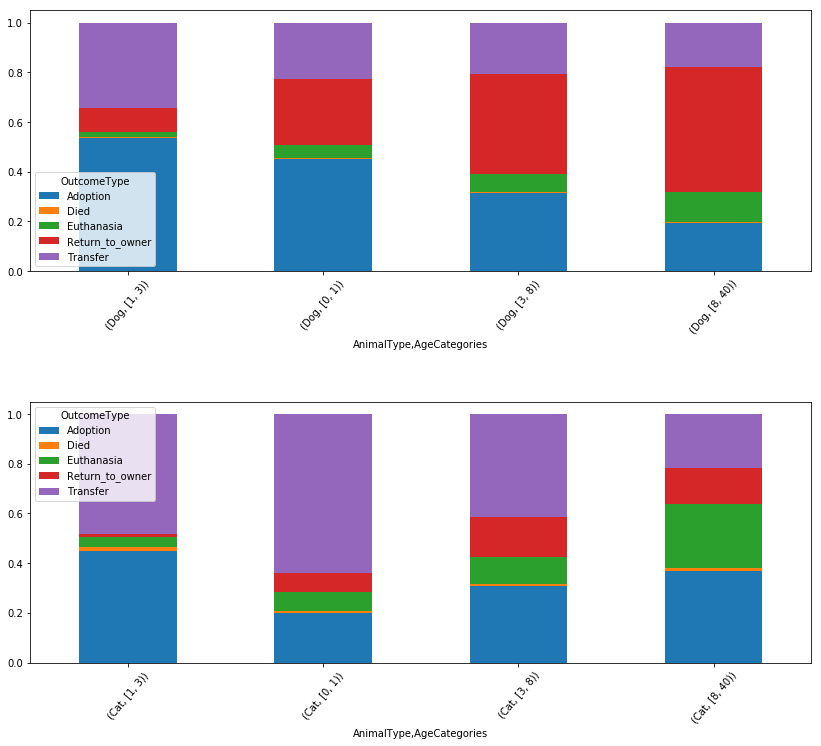

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.5)
age_xt.filter(like='Dog', axis=0).plot.bar(stacked=True, figsize=(14,12), rot=50, ax=axes[0], sharex=False)
age_xt.filter(like='Cat', axis=0).plot.bar(stacked=True, figsize=(14,12), rot=50, ax=axes[1], sharex=False)

In [33]:
sex_xt = pd.crosstab(index=[train_data.AnimalType,train_data.Sex],
                             columns=[train_data.OutcomeType],
                             normalize='index')

sex_xt

OutcomeType        Adoption      Died    ...     Return_to_owner  Transfer
AnimalType Sex                           ...                              
Cat        Female  0.424112  0.009949    ...            0.045064  0.466055
           Male    0.420272  0.014623    ...            0.052484  0.444712
Dog        Female  0.446218  0.003192    ...            0.252325  0.249410
           Male    0.394851  0.003008    ...            0.296198  0.247955

[4 rows x 5 columns]

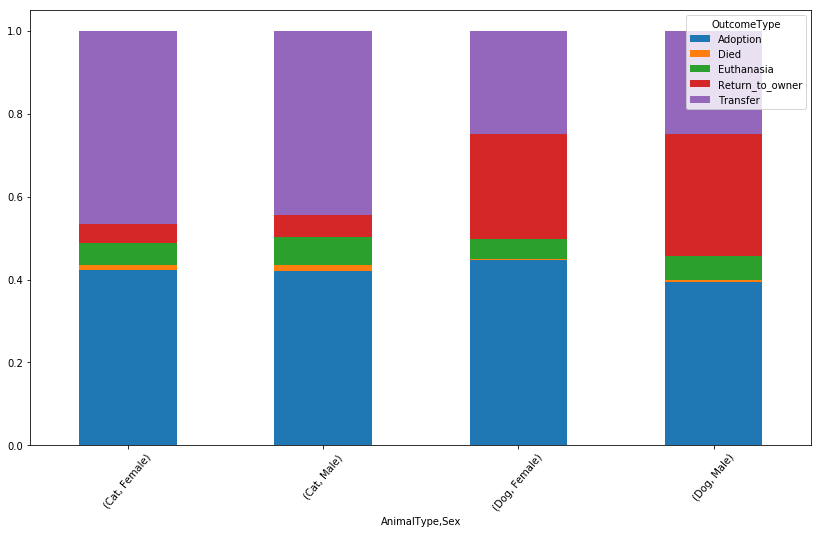

In [34]:
sex_xt.plot.bar(stacked=True, figsize=(14,8), rot=50)
# the sex of the animal doesn't seem to make a large difference in the outcome

In [35]:
single_color_xt = pd.crosstab(index=[train_data.AnimalType,train_data.SingleColor],
                             columns=[train_data.OutcomeType],
                             normalize='index')

single_color_xt

OutcomeType             Adoption      Died    ...     Return_to_owner  Transfer
AnimalType SingleColor                        ...                              
Cat        False        0.390120  0.015279    ...            0.049402  0.475936
           True         0.380186  0.012072    ...            0.042459  0.504510
Dog        False        0.428529  0.003101    ...            0.269581  0.242673
           True         0.395320  0.003394    ...            0.284209  0.266345

[4 rows x 5 columns]

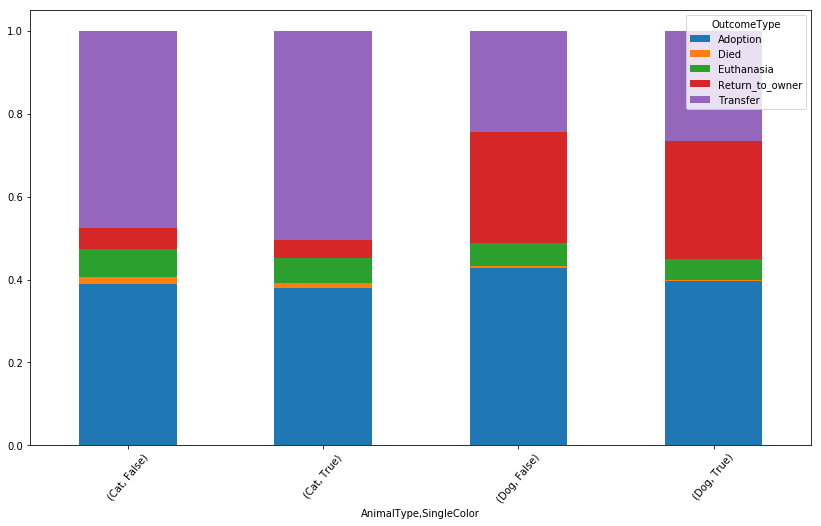

In [36]:
single_color_xt.plot.bar(stacked=True, figsize=(14,8), rot=50)
# color doesn't seem to make a difference as well

### <i><u><b>Conclusion</b></u><br>
We managed to find some trends in the data, as well as find some biases (age of the animal for instance).<br>
In order to find more complex relationships we will need the help of machine learning.<br>
We believe we have derived enough good features out of the existing data to help create a good model for predicting the outcome.<br>
We intend to use the simpler features for the model:<br>
HasName, Intact, Sex, Purebreed, SingleColor, AgeCategories.<br>
We expect features that didn't show much significance in the manual analysis to not have much importance in the machine-learning model,<br>
however we don't want to remove them before testing this assumption, since there are always surprises and hidden relations.</i>

# Machine Learning #

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import neighbors, linear_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [38]:
train_data.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,Breed1,Breed2,Breed3,Color1,Color2,Purebreed,SingleColor,Age,AgeInYears,AgeCategories
AnimalID,,,,,,,,,,,,,,,,,,,,,,
671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,False,Male,Shetland Sheepdog Mix,None,None,Brown,White,False,False,365.0,1.0,"[1, 3)"
656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,True,False,Female,Domestic Shorthair Mix,None,None,Cream Tabby,None,False,True,365.0,1.0,"[1, 3)"
686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,False,Male,Pit Bull Mix,None,None,Blue,White,False,False,730.0,2.0,"[1, 3)"
683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,False,True,Male,Domestic Shorthair Mix,None,None,Blue Cream,None,False,True,21.0,0.0,"[0, 1)"
667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,False,False,Male,Lhasa Apso,Miniature Poodle,None,Tan,None,False,True,730.0,2.0,"[1, 3)"


### Part 1 - KNearestNeighobrs and SVM

We will try to predict the animal outcome using the K-Nearest Neighbors and SVM algorithms

#### Additional data clean and pre-processing

We will drop all the textual columns, leaving only binary and numeric columns we added in the previous part.
We hope this will help the algorithms to better predictt he outcome.

In [56]:
train_data['AgeInMonths'] = (train_data.Age / 30.42).round() #average number of days per month
drop_cols=['Name','DateTime','OutcomeSubtype','SexuponOutcome','AgeuponOutcome','Breed','Color','Breed1','Breed2','Breed3','Color1','Color2','Age','AgeCategories']
# outcome_type_label_encoder = LabelEncoder()
# train_data_ml['OutcomeType'] = outcome_type_label_encoder.fit_transform(train_data_ml.OutcomeType)

In [57]:
train_data_ml = train_data.drop(columns=drop_cols)
train_data_ml = pd.get_dummies(train_data_ml, columns=['AnimalType','Sex'],drop_first=True)

We will remove additional rows with missing values. We decided to remove them instead of trying to fill them because their number is negligible compared to the rest of the data.

In [58]:
train_data_ml[train_data_ml['Intact'].isna()].index

Int64Index([667395], dtype='int64', name='AnimalID')

In [59]:
train_data_ml = train_data_ml.drop(train_data_ml[train_data_ml['Intact'].isna()].index)

In [60]:
train_data_ml[train_data_ml['Intact'].isna()].index

Int64Index([], dtype='int64', name='AnimalID')

In [61]:
train_data_ml[train_data_ml['AgeInYears'].isna()].index

Int64Index([720674, 720973, 720820, 721076, 720422, 720697, 720640, 720636,
            720701, 720782, 720780, 720653, 720652, 720534, 720781, 720908,
            721113, 720502],
           dtype='int64', name='AnimalID')

In [62]:
train_data_ml = train_data_ml.drop(train_data_ml[train_data_ml['AgeInYears'].isna()].index)

In [63]:
train_data_ml[train_data_ml['AgeInYears'].isna()].index

Int64Index([], dtype='int64', name='AnimalID')

Removing the 'AgeInYears' column because we added the 'AgeInMonths' column

In [64]:
train_data_ml = train_data_ml.drop(columns='AgeInYears')

Use get_dummies on the remaining text column. This column was significant in predicting the outcome in the previous section

In [65]:
train_data_ml = pd.get_dummies(train_data_ml, columns=['Intact'])

In [66]:
# train_data_ml = pd.get_dummies(train_data_ml, columns=['AgeInYears'])
# age_in_years_label_encoder = LabelEncoder()
# train_data_ml['AgeInYears'] = age_in_years_label_encoder.fit_transform(train_data_ml.AgeInYears)

Split the data

In [67]:
X = train_data_ml.drop(columns='OutcomeType')
y = train_data_ml.OutcomeType
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7, random_state=12345)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### SVC

We will try both linear SVC and RBF based SVC

In [68]:
svc_clf = SVC(kernel='rbf', C=1)
linear_svc_clf = LinearSVC(C=1)

In [69]:
# svc_clf.fit(X,y)

linear SVC

In [70]:
steps = [('scale', StandardScaler()), ('clf', linear_svc_clf)]
pipe = Pipeline(steps)
svc_scores = cross_val_score(pipe, X, y, cv=3)
print(f'mean: {svc_scores.mean().round(2)}, std: {svc_scores.std().round(2)}')

mean: 0.63, std: 0.0


In [72]:
pipe = Pipeline(steps)
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [73]:
print(classification_report(pipe.predict(X_test),y_test))


                 precision    recall  f1-score   support

       Adoption       0.90      0.62      0.73      4756
           Died       0.00      0.00      0.00         0
     Euthanasia       0.00      1.00      0.00         1
Return_to_owner       0.27      0.46      0.34       815
       Transfer       0.63      0.72      0.67      2441

    avg / total       0.75      0.63      0.67      8013



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


We can see that the results are better than a random guess, but are not very accurate.
We can also see that we did very poorly in predicting the 'Died' and 'Euthanasia' outcomes. This is not surprising, since their value count is very small compared to the rest of the data.
Perhaps changing the C value to a higher value will help to deal with this.

In [74]:
linear_svc_clf = LinearSVC(C=100)
steps = [('scale', StandardScaler()), ('clf', linear_svc_clf)]
pipe = Pipeline(steps)
svc_scores = cross_val_score(pipe, X, y, cv=3)
print(f'mean: {svc_scores.mean().round(2)}, std: {svc_scores.std().round(2)}')
pipe.fit(X,y)
print(classification_report(pipe.predict(X_test),y_test))

mean: 0.58, std: 0.02
                 precision    recall  f1-score   support

       Adoption       0.80      0.65      0.72      4035
           Died       0.00      0.00      0.00         0
     Euthanasia       0.01      0.04      0.02       118
Return_to_owner       0.04      0.39      0.08       152
       Transfer       0.69      0.52      0.59      3708

    avg / total       0.72      0.58      0.64      8013



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Changing "C" value to 100 did not help the prediciton. Next we will try RBF based SVC

In [75]:
steps = [('scale', StandardScaler()), ('clf', svc_clf)]
pipe2 = Pipeline(steps)


In [76]:
print(cross_val_score(pipe2, X, y, cv=3))


[0.63391353 0.64207098 0.64655657]


In [77]:
pipe2.fit(X_train,y_train)
print(classification_report(pipe2.predict(X_test),y_test))

                 precision    recall  f1-score   support

       Adoption       0.88      0.64      0.74      4565
           Died       0.00      0.00      0.00         0
     Euthanasia       0.10      0.70      0.17        66
Return_to_owner       0.36      0.48      0.41      1044
       Transfer       0.63      0.74      0.68      2338

    avg / total       0.73      0.65      0.67      8013



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


RBF based SVC does not perform well either in predicting the animal outcome results.

#### Grid Search

We decided to skip grid search for SVC because of extremely long running times that did not improve the results in the end.

In [56]:
# steps = [('scale', StandardScaler()), ('clf', SVC())]

# pipe = Pipeline(steps)

# parameters = {'clf__C': [0.1,0.5,1,10,50,100,500]}

# grid_search = GridSearchCV(pipe, parameters, cv=3)

In [57]:
#grid_search.fit(X, y)

In [58]:
#grid_search.best_score_

In [59]:
#grid_search.best_params_

### KNN

Next we will try to use a K-Nearest Neighbors predictor in order to predict the animal outcome.
We will add a scaler and PCA, and try to find the feature mix that best predicts the outcome

In [79]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [80]:
pca = PCA()
stdsc = StandardScaler()
minmax = MinMaxScaler()
maxabs = MaxAbsScaler()

In [81]:
X_trnsf = minmax.fit_transform(X,y)

In [82]:
blah = pca.fit_transform(X_trnsf,y)

In [85]:
pca.explained_variance_ratio_.cumsum()

array([0.3503117 , 0.5437875 , 0.7097542 , 0.83006418, 0.92057912,
       0.95405303, 0.98655365, 1.        , 1.        ])

In [86]:
pca = PCA(n_components=7)

In [87]:
steps = [('scale', minmax), ('pca',pca), ('clf', knn)]
# steps = [('pca',PCA(n_components=2)), ('clf', knn)]
# steps = [('scale', StandardScaler()), ('clf', knn)]

pipe = Pipeline(steps)

In [88]:
print(cross_val_score(pipe, X, y, cv=3))
pipe.fit(X_test,y_test)

[0.5937114  0.60366128 0.61397596]


Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [89]:
print(classification_report(pipe.predict(X_test),y_test))

                 precision    recall  f1-score   support

       Adoption       0.80      0.67      0.73      3973
           Died       0.00      0.00      0.00         0
     Euthanasia       0.31      0.51      0.38       295
Return_to_owner       0.44      0.45      0.45      1363
       Transfer       0.65      0.75      0.70      2382

    avg / total       0.68      0.65      0.66      8013



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


KNN did not do a good enough job either of predicting the outcome

#### Grid Search

we will try to find the optimal hyper-parameters using grid search

In [92]:
steps = [('scale', StandardScaler()), ('pca',PCA()), ('clf', neighbors.KNeighborsClassifier())]
# steps = [('pca',PCA(n_components=2)), ('clf', knn)]
# eps = [('scale', StandardScaler()), ('clf', knn)]

pipe = Pipeline(steps)

parameters = {
    'pca__n_components': range (2, 10),
    'clf__n_neighbors': range(5,306,50)}

grid_search = GridSearchCV(pipe, parameters, cv=3)

In [93]:
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': range(2, 10), 'clf__n_neighbors': range(5, 306, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
grid_search.best_score_

0.6389367278172969

In [95]:
grid_search.best_params_

{'clf__n_neighbors': 55, 'pca__n_components': 8}

### Apply Bagging

In [96]:
clf_bagging = BaggingClassifier(base_estimator=knn, n_estimators=100) 

In [97]:
clf_bagging.fit(X,y)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [98]:
clf_bagging.score(X,y)

0.6590789966304754

Bagging did not help either in improving the outcome. Not sure it's effective with KNN, since it is unsupervised and does not try to learn the mechanism behind the data.

### Apply AdaBoost

#### no good with SVC

We will skip trying to use adaptive learning because the running times were extremely long with SVC and did not show signs of improving the outcome prediction.

In [ ]:
# svc_clf = SVC(kernel='rbf', probability=True)

In [ ]:
# clf_adaboost = AdaBoostClassifier(base_estimator=svc_clf,
  #                                n_estimators=200,
  #                                learning_rate=0.02)
# clf_adaboost.fit(X, y)

In [ ]:
# clf_adaboost.fit(X,y)

### Part 1 conclusions

Both SVC and KNN did not do very well in predicting the outcome using the 'binary' features. While Death and Euthanasia have a low value count, that may help explain the poor predictions, other outcomes cannot be explained in the same way.
Seems like the features and algorithms chosen are not good enough in order to make a good prediction.


## Analysis plan
### Preprocessing
We will start by splitting the data into cats and dogs. As we saw in the investigation phase that intactness was a major indicator for transfer/adoption and HasName was a major indicator for return to owner so we are going to separate the data into 9 parts and try to model each separately:
[Dog,Cat]x[Intact,Neutered]x[Name, NoName] as well as a combined dataset Intact=='Unknown'

### Feature selection
Age will be handled in days. 
In addition we will add a calculated feature AgeCategory= [pup (0-2mo),young (2-24mo),adult(24-96mo),senior (96+ mo)]
Color - we will create dummy variables for the colors and will mark them using color1 and color2 (allowing multiple colors to have a value of 1)
Breed - we will create dummy variables for the breeds and will mark them using breed1, breed2, breed3 (allowing multiple breeds to have a value of 1)
In addition we will use the calculated features PureBreed and SingleColor as defined in the investigation phase


We will attempt to identify variables that are not in use using DecisionTree and RandomForrest to check feature importance.
Afterwards we will scale the data using MinMaxScaler and do PCA analysis 

### Model
For the model we will do  GridSearch for KNN (n_neighbors),RandomForest(max_depth), LogisticRegression (C) 
We will then create a voting ensemble with the best parameters from each category, and check for 2nd degree interactions.


In [15]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from time import time
from os import getcwd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler,PolynomialFeatures,LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import neighbors, linear_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings("ignore")

## Helper Methods

In [17]:
def get_all_dummies(data):
    colors_df1 = data[['Color1']].dropna()
    colors_df2 = data[['Color2']].dropna() 
    colors_df = pd.concat([colors_df1.rename({'Color1':'Color'}, axis=1),
                           colors_df2.rename({'Color2':'Color'}, axis=1)])
    colors_df.index.name = 'row'
    colors_df['Color'] = colors_df.Color.str.replace(' ','_')
    color_dummies = pd.get_dummies(colors_df).groupby('row').sum()

    breed_df1 =  data[['Breed1']].dropna()
    breed_df2 =  data[['Breed2']].dropna()
    breed_df3 =  data[['Breed3']].dropna()
    breeds =  pd.concat([breed_df1.rename({'Breed1':'Breed'}, axis=1),
                         breed_df2.rename({'Breed2':'Breed'}, axis=1),
                         breed_df3.rename({'Breed3':'Breed'}, axis=1),
                        ])
    breeds.index.name = 'row'
    breeds['Breed'] = breeds.Breed.str.replace(' ','_')
    breed_dummies = pd.get_dummies(breeds).groupby('row').sum()
    
    features = ['Sex', 'Purebreed', 'SingleColor', 'Age', 'AgeCategory']
    other_dummies = pd.get_dummies(data[features])
    return pd.concat([other_dummies,color_dummies,breed_dummies], axis=1, join='inner')

# We want to convert the AgeuponOutcome column to a standard value in days
def ConvertToDays(age):
    if age==None: return None
    if(' ' not in str(age)): return None
    value,unit = str(age).split()
    if 'year' in unit: return 365*int(value)
    if 'month' in unit: return 30*int(value)
    if 'week' in unit: return 7*int(value)
    if 'day' in unit:return int(value)
    return None

def GetAgeCategory(age_days):
    if(age_days==None):return None
    if(age_days <= 60): return 'Pup'
    if(age_days <= 730): return 'Young'
    if(age_days <= 2920): return 'Adult'
    return 'Senior'

def TestModel(model, X_train,y_train,X_test,y_test):
    train_accuracy = accuracy_score(y_pred=model.predict(X_train),y_true=y_train)
    test_accuracy = accuracy_score(y_pred=model.predict(X_test),y_true=y_test)
    print('train :',train_accuracy )
    print('test :', test_accuracy )
    if(hasattr(model,'best_params_') and hasattr(model,'best_score_')):
        print(model.best_params_,model.best_score_)
    return (train_accuracy, test_accuracy)

def ScrapeData(file):
    data = pd.read_csv(file)

    data['HasName'] = (data.Name.str.len() > 0)

    data[['Intact','Sex']] = data.SexuponOutcome.str.split(expand=True)
    data['Intact'] = pd.Series(np.where(data.Intact.isin(['Spayed']), 'Neutered', data.Intact))


    data[['Breed1','Breed2','Breed3']] = data.Breed.str.split('/',expand=True)

    data[['Color1','Color2']] = data.Color.str.split('/',expand=True)

    data['Purebreed'] = (~(data.Breed1.str.contains('Mix')) & data.Breed2.isna()).astype(int)
    data['SingleColor'] = data.Color2.isna().astype(int)

    data['Age'] = data.AgeuponOutcome.apply(ConvertToDays)
    data= data[data.Age >=0]
    data['AgeCategory'] = data.Age.apply(GetAgeCategory)
   
    return data
    

## Preprocessing

In [18]:
file = 'train.csv'
data = ScrapeData(file)
print(data.groupby(['AgeCategory','OutcomeType'])['OutcomeType'].value_counts())

AgeCategory  OutcomeType      OutcomeType    
Adult        Adoption         Adoption           1764
             Died             Died                 15
             Euthanasia       Euthanasia          458
             Return_to_owner  Return_to_owner    2003
             Transfer         Transfer           1383
Pup          Adoption         Adoption           3080
             Died             Died                118
             Euthanasia       Euthanasia          248
             Return_to_owner  Return_to_owner     106
             Transfer         Transfer           3396
Senior       Adoption         Adoption            323
             Died             Died                 13
             Euthanasia       Euthanasia          265
             Return_to_owner  Return_to_owner     621
             Transfer         Transfer            265
Young        Adoption         Adoption           5602
             Died             Died                 51
             Euthanasia       Euthan

### Split data

In [19]:
dogs_intact_named= data[(data.AnimalType == 'Dog') & (data.Intact == 'Intact') & (data.HasName==True)]
dogs_intact_unnamed= data[(data.AnimalType == 'Dog') & (data.Intact == 'Intact') & (data.HasName==False)]
dogs_neutered_named= data[(data.AnimalType == 'Dog') & (data.Intact == 'Neutered') & (data.HasName==True)]
dogs_neutered_unnamed= data[(data.AnimalType == 'Dog') & (data.Intact == 'Neutered') & (data.HasName==False)]

cats_intact_named= data[(data.AnimalType == 'Cat') & (data.Intact == 'Intact') & (data.HasName==True)]
cats_intact_unnamed= data[(data.AnimalType == 'Cat') & (data.Intact == 'Intact') & (data.HasName==False)]
cats_spayed_named= data[(data.AnimalType == 'Cat') & (data.Intact == 'Neutered') & (data.HasName==True)]
cats_spayed_unnamed= data[(data.AnimalType == 'Cat') & (data.Intact == 'Neutered') & (data.HasName==False)]

unknown = data[(data.Intact == 'Unknown')]



## Model
### Unknown

In [21]:
X = pd.get_dummies(unknown[['Age', 'AnimalType','HasName']],columns=['AnimalType','HasName'])
y = unknown.OutcomeType


X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

weights = {'Died':0,'Euthanasia':1,'Transfer':1,'Return_to_owner':5}
grid_search_dtc = GridSearchCV(DecisionTreeClassifier(class_weight=weights), {'max_depth':range(1,10)}, cv=5)
grid_search_dtc.fit(X_train,y_train)
accuracy = TestModel(grid_search_dtc,X_train,y_train,X_test,y_test)

grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight=weights), {'max_depth':range(1,10)}, cv=5)
grid_search_rf.fit(X_train,y_train)
accuracy = TestModel(grid_search_rf,X_train,y_train,X_test,y_test)

pipe_slr= Pipeline([('scaler',StandardScaler()),('model',LogisticRegression())])
grid_search_slr = GridSearchCV(pipe_slr, {'model__C':[0.1,0.5,1,5,10,50,100]}, cv=5)
grid_search_slr.fit(X_train,y_train)
accuracy = TestModel(grid_search_slr,X_train,y_train,X_test,y_test)

grid_search_lr = GridSearchCV(LogisticRegression(), {'C':[0.1,0.5,1,5,10,50,100]}, cv=5)
grid_search_lr.fit(X_train,y_train)
accuracy = TestModel(grid_search_lr,X_train,y_train,X_test,y_test)

pipe_knn= Pipeline([('scaler',StandardScaler()),('model',neighbors.KNeighborsClassifier())])
grid_search_knn = GridSearchCV(pipe_knn, {'model__n_neighbors':range(5,50,5)}, cv=5)
grid_search_knn.fit(X_train,y_train)
accuracy = TestModel(grid_search_knn,X_train,y_train,X_test,y_test)

# running several times shows that the most stable model is the LR wih C=0.1

train : 0.8858267716535433
test : 0.8715596330275229
{'max_depth': 3} 0.8792650918635171
train : 0.9015748031496063
test : 0.8960244648318043
{'max_depth': 6} 0.8832020997375328
train : 0.8832020997375328
test : 0.8776758409785933
{'model__C': 0.1} 0.8818897637795275
train : 0.8832020997375328
test : 0.8776758409785933
{'C': 0.1} 0.8832020997375328
train : 0.8937007874015748
test : 0.8837920489296636
{'model__n_neighbors': 10} 0.8871391076115486


In [22]:
#check if voting improves result  
#class weights were causing a problem because they were not always present (which makes no sense because they are present)
grid_search_rf.best_estimator_.class_weight = None 
classifiers = [grid_search_knn.best_estimator_,grid_search_slr.best_estimator_,grid_search_rf.best_estimator_]
classifier_names = ['knn','scaled_lr','rf']
vc = VotingClassifier(estimators=list(zip(classifier_names,classifiers)),voting='soft')
vc.fit(X_train,y_train)
accuracy = TestModel(vc,X_train,y_train,X_test,y_test)

#voting doesn't significantly improve accuracy

train : 0.8963254593175853
test : 0.8837920489296636


### building the model (using dogs_intact_named)

In [24]:
X = get_all_dummies(dogs_intact_named)
y = dogs_intact_named.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
X_train.shape

(1333, 250)

In [10]:
#Decison tree classifier baseline
#Check using balanced class weights and no weights
#Run grid search to find optimal depth, minimum samples per leaf
for class_weight in ['balanced',None]:
    dtc = DecisionTreeClassifier(class_weight=class_weight)
    grid_search_dtc = GridSearchCV(dtc, {'max_depth':range(1,10), 'min_samples_leaf':range(1,10,2)}, cv=5)
    grid_search_dtc.fit(X_train,y_train)
    accuracy = TestModel(grid_search_dtc,X_train,y_train,X_test,y_test)
   

train : 0.477119279819955
test : 0.3741258741258741
{'max_depth': 9, 'min_samples_leaf': 1} 0.40585146286571644
train : 0.568642160540135
test : 0.5367132867132867
{'max_depth': 6, 'min_samples_leaf': 9} 0.5296324081020255


In [11]:
#Random forest classifier baseline
#Run grid search to find optimal depth, minimum samples per leaf
#Max depth limited to 6 to prevent overfit

rfc = RandomForestClassifier()
grid_search_rfc = GridSearchCV(rfc, {'max_depth':range(1,7), 'min_samples_leaf':range(2,10,2)}, cv=5)
grid_search_rfc.fit(X_train,y_train)
accuracy = TestModel(grid_search_rfc,X_train,y_train,X_test,y_test)



train : 0.5468867216804201
test : 0.5122377622377622
{'max_depth': 5, 'min_samples_leaf': 4} 0.5318829707426856


(0.5468867216804201, 0.5122377622377622)

In [12]:
#check Logistic regression using best features from rf importance 
#(with different thresholds for which features are used)
imps = list(zip(grid_search_rfc.best_estimator_.feature_importances_ ,X.columns))
sorted_imps = sorted(imps,key=lambda x:x[0],reverse=True)

for imp_threshold in np.linspace(-0.05,0.1,4):
    best_features = [imp[1] for imp in sorted_imps if imp[0]>imp_threshold]
    grid_search_lr = GridSearchCV(LogisticRegression(), {'C':[0.1,0.5,1,5,10,50,100]}, cv=5)
    grid_search_lr.fit(X_train[best_features],y_train)
    accuracy = TestModel(grid_search_lr,X_train[best_features],y_train,X_test[best_features],y_test)
    
# best result is with all features

train : 0.6084021005251313
test : 0.5594405594405595
{'C': 0.5} 0.5581395348837209
train : 0.5701425356339085
test : 0.541958041958042
{'C': 1} 0.5446361590397599
train : 0.5221305326331583
test : 0.5034965034965035
{'C': 0.5} 0.5258814703675919
train : 0.5183795948987246
test : 0.5017482517482518
{'C': 0.1} 0.5176294073518379


In [25]:
#check Logistic regression using scaling and PCA


pipe = Pipeline([('scaler',StandardScaler()),('pca',PCA()),('model',LogisticRegression())])
params = {'model__C':[0.1,0.5,1,5,10,50,100],
          'pca__n_components':[1,5,20,50,100]}
grid_search_slr = GridSearchCV(pipe,params, cv=5)
grid_search_slr.fit(X_train,y_train)
accuracy = TestModel(grid_search_slr,X_train,y_train,X_test,y_test)
    
# no improvement when using PCA

train : 0.568642160540135
test : 0.5192307692307693
{'model__C': 0.1, 'pca__n_components': 50} 0.5378844711177795


In [26]:
#check KNN, gridsearch on n_neighbors
pipe_knn= Pipeline([('scaler',StandardScaler()),('model',neighbors.KNeighborsClassifier())])
grid_search_knn = GridSearchCV(pipe_knn, {'model__n_neighbors':range(5,50,5)}, cv=5)
grid_search_knn.fit(X_train,y_train)
accuracy = TestModel(grid_search_knn,X_train,y_train,X_test,y_test)

train : 0.5656414103525882
test : 0.5192307692307693
{'model__n_neighbors': 30} 0.5221305326331583


In [27]:
#check if voting improves result  
knn = Pipeline([('scaler',StandardScaler()),('model',neighbors.KNeighborsClassifier(n_neighbors=30))])
lr = LogisticRegression(C=0.5)
rf = RandomForestClassifier(max_depth=6,min_samples_leaf=8)
classifiers = [knn,lr,rf]
classifier_names = ['knn','lr','rf']
vc = VotingClassifier(estimators=list(zip(classifier_names,classifiers)),voting='soft')
vc.fit(X_train,y_train)
accuracy = TestModel(vc,X_train,y_train,X_test,y_test)

#No improvement over logistic regression C=0.5

train : 0.5963990997749438
test : 0.5594405594405595


In [28]:
#Check for interaction
pipe = Pipeline([('scale',MinMaxScaler()),('inter',PolynomialFeatures(interaction_only=True)), ('var',VarianceThreshold(0.01)),('model',LogisticRegression(C=0.5))])
pipe.fit(X_train,y_train)
accuracy = TestModel(pipe,X_train,y_train,X_test,y_test)

train : 0.6046511627906976
test : 0.5611888111888111


### Model Checking Algorithm
After tweaking the cells above to get best performance I will wrap them in methods so I can run it on each of the 8 split parts.

In [29]:
def Check_Dtc(X_train, X_test,y_train,y_test):
    print('\nChecking DecisionTreeClassifier')
    scores = []
    for class_weight in ['balanced',None]:
        print('class_weight=',class_weight)
        dtc = DecisionTreeClassifier(class_weight=class_weight)
        grid_search_dtc = GridSearchCV(dtc, {'max_depth':range(1,10), 'min_samples_leaf':range(1,10,2)}, cv=5)
        grid_search_dtc.fit(X_train,y_train)
        accuracy = TestModel(grid_search_dtc,X_train,y_train,X_test,y_test)
        scores.append((grid_search_dtc.best_estimator_, accuracy[1]))
    
    return max(scores,key=lambda pair:pair[1])[0]
    
def Check_RandomForest(X_train, X_test,y_train,y_test):
    print('\nChecking RandomForest')
    rfc = RandomForestClassifier()
    grid_search_rfc = GridSearchCV(rfc, {'max_depth':range(1,7), 'min_samples_leaf':range(2,10,2)}, cv=5)
    grid_search_rfc.fit(X_train,y_train)
    TestModel(grid_search_rfc,X_train,y_train,X_test,y_test)
    importances = list(zip(grid_search_rfc.best_estimator_.feature_importances_ ,X.columns))
    sorted_imps = sorted(importances,key=lambda x:x[0],reverse=True)
    return  (grid_search_rfc.best_estimator_,sorted_imps)
    
def Check_LogisticRegression(X_train, X_test,y_train,y_test,importances):
    scores = []
    print('\nChecking LogisticRegression')
    for imp_threshold in np.linspace(-0.05,0.1,4):
        best_features = [imp[1] for imp in importances if imp[0]>imp_threshold]
        print(f'Using {len(best_features)} features')
        grid_search_lr = GridSearchCV(LogisticRegression(), {'C':[0.1,0.5,1,5,10,50,100]}, cv=5)
        grid_search_lr.fit(X_train[best_features],y_train)
        accuracy = TestModel(grid_search_lr,X_train[best_features],y_train,X_test[best_features],y_test)
        scores.append((grid_search_lr.best_estimator_, accuracy[1]))
    
    return max(scores,key=lambda pair:pair[1])[0]
        

def Check_LogisiticRegressionPCA(X_train, X_test,y_train,y_test):
    print('\nChecking LogisiticRegression with PCA')
    pipe = Pipeline([('scaler',StandardScaler()),('pca',PCA()),('model',LogisticRegression())])
    params = {'model__C':[0.1,0.5,1,5,10,50,100],
              'pca__n_components':[1,5,20,50]}
    grid_search_slr = GridSearchCV(pipe,params, cv=5)
    grid_search_slr.fit(X_train,y_train)
    TestModel(grid_search_slr,X_train,y_train,X_test,y_test)
    return grid_search_slr.best_estimator_
    
def Check_Knn(X_train, X_test,y_train,y_test):
    print('\nChecking KNN')
    pipe_knn= Pipeline([('scaler',StandardScaler()),('model',neighbors.KNeighborsClassifier())])
    grid_search_knn = GridSearchCV(pipe_knn, {'model__n_neighbors':range(5,50,5)}, cv=5)
    grid_search_knn.fit(X_train,y_train)
    TestModel(grid_search_knn,X_train,y_train,X_test,y_test)
    return grid_search_knn.best_estimator_

def Check_Voting(X_train, X_test,y_train,y_test,estimators):
    print('\nChecking Voting')
    vc = VotingClassifier(estimators=estimators,voting='soft')
    vc.fit(X_train,y_train)
    TestModel(vc,X_train,y_train,X_test,y_test)
    return vc
    
def Check_Interactions(X_train, X_test,y_train,y_test):
    print('\nChecking Interactions')
    pipe = Pipeline([('scale',MinMaxScaler()),('inter',PolynomialFeatures(interaction_only=True)), ('var',VarianceThreshold(0.01)),('model',LogisticRegression(C=0.5))])
    pipe.fit(X_train,y_train)
    TestModel(pipe,X_train,y_train,X_test,y_test)
    return pipe

def Check_All(X_train, X_test,y_train,y_test):
    dtc = Check_Dtc(X_train, X_test,y_train,y_test)
    rf,importances = Check_RandomForest(X_train, X_test,y_train,y_test)
    lr = Check_LogisticRegression(X_train, X_test,y_train,y_test,importances)
    lr_pca = Check_LogisiticRegressionPCA(X_train, X_test,y_train,y_test)
    knn = Check_Knn(X_train, X_test,y_train,y_test)
    estimators = [('knn',knn),('rf',rf),('lr',lr)]
    vc = Check_Voting(X_train, X_test,y_train,y_test,estimators)
    inter = Check_Interactions(X_train, X_test,y_train,y_test)
    return {'dtc':dtc,'rf':rf,'lr':lr,'lr_pca':lr_pca,'knn':knn,'vc':vc,'inter':inter}

### dogs_intact_named

In [30]:
X = get_all_dummies(dogs_intact_named)
y = dogs_intact_named.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(1333, 250)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.477119279819955
test : 0.3758741258741259
{'max_depth': 9, 'min_samples_leaf': 1} 0.4081020255063766
class_weight= None
train : 0.568642160540135
test : 0.5367132867132867
{'max_depth': 6, 'min_samples_leaf': 9} 0.5296324081020255

Checking RandomForest
train : 0.5401350337584396
test : 0.5262237762237763
{'max_depth': 5, 'min_samples_leaf': 2} 0.5303825956489122

Checking LogisticRegression
Using 250 features
train : 0.6084021005251313
test : 0.5594405594405595
{'C': 0.5} 0.5588897224306076
Using 53 features
train : 0.5716429107276819
test : 0.5437062937062938
{'C': 0.5} 0.5528882220555139
Using 6 features
train : 0.5333833458364591
test : 0.541958041958042
{'C': 1} 0.5311327831957989
Using 2 features
train : 0.5183795948987246
test : 0.4982517482517482
{'C': 0.1} 0.5198799699924981

Checking LogisiticRegression with PCA
train : 0.5753938484621155
test : 0.5297202797202797
{'model__C': 5, 'pca__n_components'

### dogs_intact_unnamed

In [31]:
X = get_all_dummies(dogs_intact_unnamed)
y = dogs_intact_unnamed.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(762, 174)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.6167979002624672
test : 0.5412844036697247
{'max_depth': 8, 'min_samples_leaf': 1} 0.5997375328083989
class_weight= None
train : 0.7664041994750657
test : 0.7553516819571865
{'max_depth': 4, 'min_samples_leaf': 7} 0.7532808398950132

Checking RandomForest
train : 0.7283464566929134
test : 0.72782874617737
{'max_depth': 6, 'min_samples_leaf': 2} 0.7230971128608924

Checking LogisticRegression
Using 174 features
train : 0.7716535433070866
test : 0.7308868501529052
{'C': 0.5} 0.7414698162729659
Using 53 features
train : 0.7664041994750657
test : 0.7370030581039755
{'C': 0.5} 0.7467191601049868
Using 5 features
train : 0.7454068241469817
test : 0.7431192660550459
{'C': 0.5} 0.7388451443569554
Using 2 features
train : 0.7322834645669292
test : 0.72782874617737
{'C': 0.1} 0.7322834645669292

Checking LogisiticRegression with PCA
train : 0.7362204724409449
test : 0.7155963302752294
{'model__C': 0.1, 'pca__n_component

### dogs_neutered_named

In [32]:
X = get_all_dummies(dogs_neutered_named)
y = dogs_neutered_named.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)

#knn,vc,inter takes too long to grid search on this data set due to its size
dtc = Check_Dtc(X_train, X_test,y_train,y_test)
rf,importances = Check_RandomForest(X_train, X_test,y_train,y_test)
lr = Check_LogisticRegression(X_train, X_test,y_train,y_test,importances)
lr_pca = Check_LogisiticRegressionPCA(X_train, X_test,y_train,y_test)
#knn =  Pipeline([('scaler',StandardScaler()),('model',neighbors.KNeighborsClassifier(n_neighbors=30))])
#estimators = [('knn',knn),('rf',rf),('lr',lr)]
#vc = Check_Voting(X_train, X_test,y_train,y_test,estimators)
#inter = Check_Interactions(X_train, X_test,y_train,y_test)

(7704, 381)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.4732606438213915
test : 0.43337371290127197
{'max_depth': 9, 'min_samples_leaf': 5} 0.4523624091381101
class_weight= None
train : 0.5433541017653167
test : 0.5336159903089037
{'max_depth': 1, 'min_samples_leaf': 1} 0.5433541017653167

Checking RandomForest
train : 0.5376427829698858
test : 0.5405814657783161
{'max_depth': 6, 'min_samples_leaf': 2} 0.5301142263759087

Checking LogisticRegression
Using 381 features
train : 0.5552959501557633
test : 0.5411871592973955
{'C': 0.5} 0.5454309449636553
Using 92 features
train : 0.547767393561786
test : 0.5357359176256814
{'C': 50} 0.5429646936656283
Using 4 features
train : 0.5404984423676013
test : 0.5327074500302846
{'C': 0.1} 0.5404984423676013
Using 4 features
train : 0.5404984423676013
test : 0.5327074500302846
{'C': 0.1} 0.5404984423676013

Checking LogisiticRegression with PCA
train : 0.5425752855659398
test : 0.5427013930950939
{'model__C': 100, 'pca__n_compo

### dogs_neutered_unnamed

In [33]:
X = get_all_dummies(dogs_neutered_unnamed)
y = dogs_neutered_unnamed.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(1061, 242)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.6870876531573987
test : 0.6857142857142857
{'max_depth': 1, 'min_samples_leaf': 1} 0.6748350612629594
class_weight= None
train : 0.6946277097078228
test : 0.6967032967032967
{'max_depth': 2, 'min_samples_leaf': 1} 0.6936852026390198

Checking RandomForest
train : 0.6852026390197926
test : 0.6791208791208792
{'max_depth': 4, 'min_samples_leaf': 2} 0.6833176248821866

Checking LogisticRegression
Using 242 features
train : 0.7530631479736098
test : 0.7098901098901099
{'C': 0.5} 0.702167766258247
Using 42 features
train : 0.7351555136663525
test : 0.6857142857142857
{'C': 10} 0.705937794533459
Using 4 features
train : 0.700282752120641
test : 0.6989010989010989
{'C': 0.5} 0.700282752120641
Using 2 features
train : 0.6852026390197926
test : 0.6791208791208792
{'C': 0.5} 0.6852026390197926

Checking LogisiticRegression with PCA
train : 0.7163053722902922
test : 0.6967032967032967
{'model__C': 0.1, 'pca__n_component

### cats_intact_named

In [39]:
X = get_all_dummies(cats_intact_named)
y = cats_intact_named.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(758, 60)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.525065963060686
test : 0.37538461538461537
{'max_depth': 9, 'min_samples_leaf': 1} 0.39841688654353563
class_weight= None
train : 0.6675461741424802
test : 0.6676923076923077
{'max_depth': 1, 'min_samples_leaf': 1} 0.6675461741424802

Checking RandomForest
train : 0.6675461741424802
test : 0.6707692307692308
{'max_depth': 5, 'min_samples_leaf': 2} 0.6701846965699209

Checking LogisticRegression
Using 60 features
train : 0.6675461741424802
test : 0.6676923076923077
{'C': 0.1} 0.6662269129287599
Using 32 features
train : 0.6675461741424802
test : 0.6676923076923077
{'C': 0.1} 0.6662269129287599
Using 4 features
train : 0.6675461741424802
test : 0.6676923076923077
{'C': 0.1} 0.6675461741424802
Using 2 features
train : 0.6675461741424802
test : 0.6676923076923077
{'C': 0.1} 0.6675461741424802

Checking LogisiticRegression with PCA
train : 0.6675461741424802
test : 0.6676923076923077
{'model__C': 0.1, 'pca__n_compon

### cats_intact_unnamed

In [40]:
X = get_all_dummies(cats_intact_unnamed)
y = cats_intact_unnamed.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(2062, 64)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.5722599418040737
test : 0.49095022624434387
{'max_depth': 9, 'min_samples_leaf': 1} 0.5286129970902037
class_weight= None
train : 0.8608147429679922
test : 0.8585972850678733
{'max_depth': 1, 'min_samples_leaf': 1} 0.8608147429679922

Checking RandomForest
train : 0.8627546071774975
test : 0.8653846153846154
{'max_depth': 6, 'min_samples_leaf': 2} 0.8574199806013579

Checking LogisticRegression
Using 64 features
train : 0.8622696411251213
test : 0.8619909502262444
{'C': 1} 0.8612997090203686
Using 34 features
train : 0.8608147429679922
test : 0.8619909502262444
{'C': 0.5} 0.8603297769156159
Using 3 features
train : 0.8593598448108632
test : 0.8642533936651584
{'C': 0.1} 0.8593598448108632
Using 2 features
train : 0.8593598448108632
test : 0.8642533936651584
{'C': 0.1} 0.8593598448108632

Checking LogisiticRegression with PCA
train : 0.8642095053346266
test : 0.8574660633484162
{'model__C': 0.1, 'pca__n_compone

### cats_spayed_named

In [41]:
X = get_all_dummies(cats_spayed_named)
y = cats_spayed_named.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)

(3504, 90)

Checking DecisionTreeClassifier
class_weight= balanced
train : 0.6115867579908676
test : 0.5199733688415447
{'max_depth': 9, 'min_samples_leaf': 1} 0.5259703196347032
class_weight= None
train : 0.6783675799086758
test : 0.6790945406125166
{'max_depth': 1, 'min_samples_leaf': 1} 0.6783675799086758

Checking RandomForest
train : 0.6783675799086758
test : 0.6784287616511319
{'max_depth': 6, 'min_samples_leaf': 6} 0.680079908675799

Checking LogisticRegression
Using 90 features
train : 0.6749429223744292
test : 0.6764314247669774
{'C': 0.1} 0.6740867579908676
Using 36 features
train : 0.675513698630137
test : 0.6764314247669774
{'C': 0.1} 0.6740867579908676
Using 4 features
train : 0.6786529680365296
test : 0.6804260985352862
{'C': 0.1} 0.6786529680365296
Using 3 features
train : 0.6789383561643836
test : 0.6790945406125166
{'C': 0.5} 0.6786529680365296

Checking LogisiticRegression with PCA
train : 0.6783675799086758
test : 0.6790945406125166
{'model__C': 0.1, 'pca__n_componen

### cats_spayed_unnamed

In [ ]:
X = get_all_dummies(cats_spayed_unnamed)
y = cats_spayed_unnamed.OutcomeType

X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=3475)
print(X_train.shape)
classifiers = Check_All(X_train, X_test,y_train,y_test)
#best is DTC

# Summary
The best models seem to be LogisticRegression and RandomForest with some small exceptions.
Using class_weights on the DTC didn't help and neither did PCA analysis
Voting and interaction for the most part didn't help and in order to keep the model simple we will not use these.
KNN did not significantly improve accuracy and in order to reduce memory overhead we will not use this either.


# Test Data

In [121]:
file = 'test.csv'

data = ScrapeData(file)

test_dogs_intact_named= data[(data.AnimalType == 'Dog') & (data.Intact == 'Intact') & (data.HasName==True)]
test_dogs_intact_unnamed= data[(data.AnimalType == 'Dog') & (data.Intact == 'Intact') & (data.HasName==False)]
test_dogs_neutered_named= data[(data.AnimalType == 'Dog') & (data.Intact == 'Neutered') & (data.HasName==True)]
test_dogs_neutered_unnamed= data[(data.AnimalType == 'Dog') & (data.Intact == 'Neutered') & (data.HasName==False)]

test_cats_intact_named= data[(data.AnimalType == 'Cat') & (data.Intact == 'Intact') & (data.HasName==True)]
test_cats_intact_unnamed= data[(data.AnimalType == 'Cat') & (data.Intact == 'Intact') & (data.HasName==False)]
test_cats_spayed_named= data[(data.AnimalType == 'Cat') & (data.Intact == 'Neutered') & (data.HasName==True)]
test_cats_spayed_unnamed= data[(data.AnimalType == 'Cat') & (data.Intact == 'Neutered') & (data.HasName==False)]

test_unknown = data[(data.Intact == 'Unknown')]



In [119]:
def Get_Mutual_Columns(X_train,X_test):
    train_col = set(X_train.columns)
    test_col = set(X_test.columns)
    #print('Test missing columns = ',train_col-test_col)
    #print('Test extra columns = ',test_col-train_col)
    mutual_col = train_col & test_col
    return (X_train[list(mutual_col)], X_test[list(mutual_col)])

def predict(train,test,model):
    X_train = get_all_dummies(train)
    y = train.OutcomeType
    X_test = get_all_dummies(test)
    X_train, X_test = Get_Mutual_Columns(X_train,X_test)

    model.fit(X_train,y)
    return pd.Series(model.predict(X_test), index=test.ID)
    #return pd.Series(model.predict(X_test))

In [122]:
X_train = pd.get_dummies(unknown[['Age', 'AnimalType','HasName']],columns=['AnimalType','HasName'])
X_test = pd.get_dummies(test_unknown[['Age', 'AnimalType','HasName']],columns=['AnimalType','HasName'])
y=unknown.OutcomeType
lr = LogisticRegression(C=0.1)
lr.fit(X_train,y)
unknown_pred = pd.Series(lr.predict(X_test), index=test_unknown.ID)
#unknown_pred = pd.Series(lr.predict(X_test))
dogs_intact_named_pred = predict(dogs_intact_named,test_dogs_intact_named,LogisticRegression(C=0.5))
dogs_intact_unnamed_pred = predict(dogs_intact_unnamed,test_dogs_intact_unnamed,DecisionTreeClassifier(max_depth=4, min_samples_leaf=7))
dogs_neutered_named_pred = predict(dogs_neutered_named,test_dogs_neutered_named,LogisticRegression(C=0.5))
dogs_neutered_unnamed_pred = predict(dogs_neutered_unnamed,test_dogs_neutered_unnamed,LogisticRegression(C=0.5))
cats_intact_named_pred = predict(cats_intact_named,test_cats_intact_named,LogisticRegression(C=0.1))
cats_intact_unnamed_pred = predict(cats_intact_unnamed,test_cats_intact_unnamed,LogisticRegression(C=1))
cats_spayed_named_pred = predict(cats_spayed_named,test_cats_spayed_named,LogisticRegression(C=0.1))
cats_spayed_unnamed_pred = predict(cats_spayed_unnamed,test_cats_spayed_unnamed,LogisticRegression(C=0.1))
all_pred =  unknown_pred
all_pred= all_pred.append(dogs_intact_named_pred,verify_integrity=True)
all_pred= all_pred.append(dogs_intact_unnamed_pred,verify_integrity=True)
all_pred= all_pred.append(dogs_neutered_named_pred,verify_integrity=True)
all_pred= all_pred.append(dogs_neutered_unnamed_pred,verify_integrity=True)
all_pred= all_pred.append(cats_intact_named_pred,verify_integrity=True)
all_pred= all_pred.append(cats_intact_unnamed_pred,verify_integrity=True)
all_pred= all_pred.append(cats_spayed_named_pred,verify_integrity=True)
all_pred= all_pred.append(cats_spayed_unnamed_pred,verify_integrity=True) 

### Submission

In [129]:
print(all_pred.shape, pd.read_csv('test.csv').shape)
missing_rows = set(range(1,11457)) - set(all_pred.index)
for missing_row in missing_rows:
    all_pred[missing_row] = 'Transfer'
#all_pred = all_pred.sort_index()
print(all_pred.shape, pd.read_csv('test.csv').shape)

(11450,) (11456, 8)
(11456,) (11456, 8)


In [130]:
print(set(all_pred.index)-set(data.index))
print(set(data.index)-set(all_pred.index))

{11456, 2498, 10754, 7626, 6347, 6323, 763}
{0}


In [131]:
pred_df = pd.DataFrame()
pred_df['pred'] = all_pred
pred_df.index = all_pred.index

In [132]:
with open('submission.csv','w+') as sub:
    sub.write('ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer\n')
    for row_id,values in pred_df.iterrows() :
        pred = values['pred']
        adoption = '0'
        if(pred=='Adoption'): adoption = '1'
        died = '0'
        if(pred=='Died'): died = '1'
        euthanasia = '0'
        if(pred=='Euthanasia'): euthanasia = '1'
        return_to_owner= '0'
        if(pred=='Return_to_owner'): return_to_owner = '1'
        transfer = '0'
        if(pred=='Transfer'): transfer = '1'
        sub_str = ','.join([str(row_id),adoption,died,euthanasia,return_to_owner,transfer])
        sub.write(sub_str)
        sub.write('\n')
        

In [133]:
#submission by percentages
with open('submission2.csv','w+') as sub:
    sub.write('ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer\n')
    lines = [f'{row_id},10769,197,1555,4786,9422\n' for row_id in range(1,11457)]
    sub.writelines(lines)